**Import Dataset "MNIST" and Set Up Training Environment**

In [1]:
# Verify access to GPU and initiate PyTorch
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_capability(0))
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

True
NVIDIA GeForce RTX 2060
(7, 5)


'cuda:0'

In [2]:
import os
import torchvision
from torchvision import transforms

# Define the directory download and store the 'MNIST' dataset
download_path = os.getcwd()+ '\MNIST'

# Define the transformation
transform = transforms.ToTensor()

# Set the batch size
batch_size = 8

# Create the training dataset object, set download to False if data exists
trainset = torchvision.datasets.MNIST(root=download_path, train=True, download=False, transform=transform)

# Create the test dataset object, set download to False if data exists
testset = torchvision.datasets.MNIST(root=download_path, train=False, download=False, transform=transform)

# The number of classes for training labels
# In this case we have integers ranging from 0 to 9, so it's 10 classes in total
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Get the shape of the tensor, we need this info to create a CNN model
# that is suitable for the datasets;
# Get the first tuple representing the tensor and its label (image, integer)
train_iter = iter(trainset)
image, label = next(train_iter)


print(f'The shape of the tensor is: {image.shape, label}')
# Tensor with one channel, each data point in the batch represents a 28
# x28 tensor, and this tensor has a label of 5 ('Five').
# The images ("tensors") are relatively small and I don't think we need to 
# resize them

The shape of the tensor is: (torch.Size([1, 28, 28]), 5)


In [3]:
# Confirm that labels are stored correctly
print(trainset.class_to_idx)

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


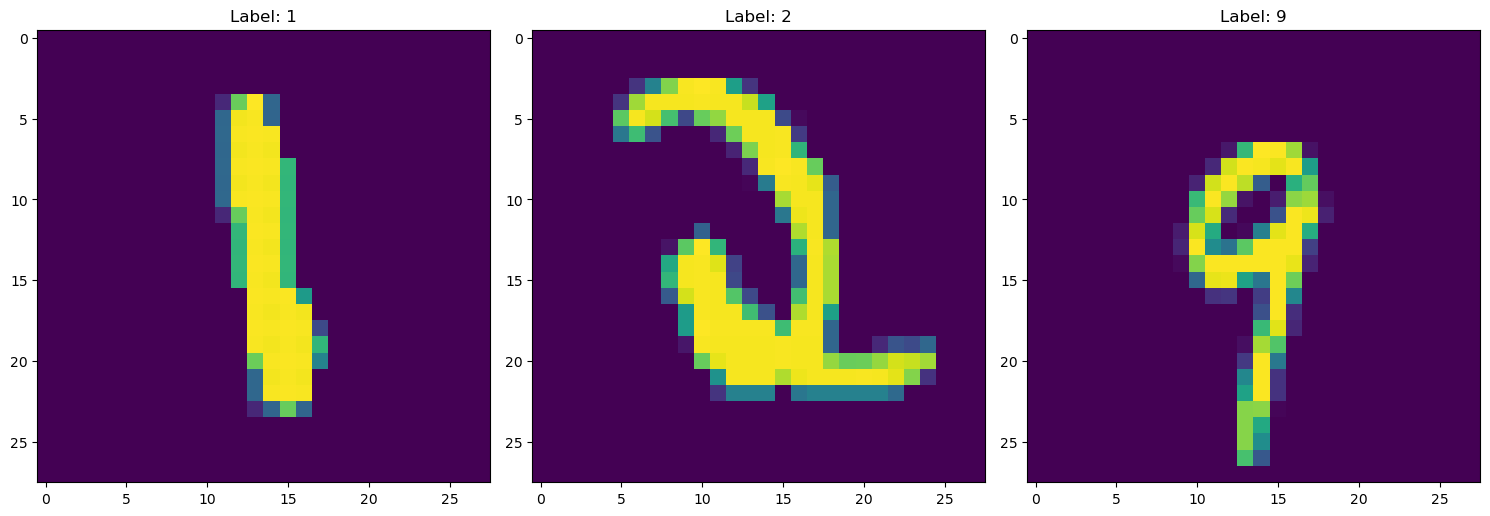

In [4]:
import matplotlib.pyplot as plt

# Visualize some tensors to check if their labels are correct

# Get three samples
indices = [200, 400, 600]

# Create a plot with 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

for i, ax in zip(indices, axes):
    image, label = trainset[i]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Label: {classes[label]}")

plt.tight_layout()
plt.show()

**Create Training and Validation Datasets from Training**

In [5]:
print(f'The training dataset has {len(trainset)} tensors,\n'
      f'and the test dataset has {len(testset)} features'
)

The training dataset has 60000 tensors,
and the test dataset has 10000 features


In [6]:
# Create a subset of the training dataset with a 70/30 split
trainset, valset = torch.utils.data.random_split(trainset, [42000, 18000])

print(f'The training dataset has {len(trainset)} tensors;\n'
      f'and the validation dataset has {len(valset)} features; \n'
      f'The test dataset has {len(testset)} tensors.'
)

# Verify the number of batches that will be divided during training
print(f'Number of batches in the training set: {int(42000 / batch_size)}')
print(f'Number of batches in the validation set: {int(18000 / batch_size)}')

The training dataset has 42000 tensors;
and the validation dataset has 18000 features; 
The test dataset has 10000 tensors.
Number of batches in the training set: 5250
Number of batches in the validation set: 2250


**Model Preparation**

In [8]:
# Instantiate data loders to transfer data from CPU to GPU
# Increase num_workers (#subprocesses) to speed up data loading if needed

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# Define CNN Architecture

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers (set number of channel to 1)
        # Also change "out_channels" if model performance is not good
        # underfitting -> increase #channels, overfitting -> reduce #channels
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Calculate the size of the flattened features after all convolutional and pooling layers
        self._flattened_features = self._get_conv_output_size()

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=self._flattened_features, out_features=1024)
        self.drop1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.drop2 = nn.Dropout(p=0.3)
        # Change out_features to match the number of classes, which is 10 (0-9)
        self.out = nn.Linear(in_features=512, out_features=10)

    def _get_conv_output_size(self):
        # Create a dummy input to pass through the convolutional layers only
        # The dimension of my tensor is [1,1,28,28]
        dummy_input = torch.zeros(1, 1, 28, 28)  # Use the provided input dimensions
        dummy_input = self.conv1(dummy_input)
        dummy_input = self.pool1(dummy_input)
        dummy_input = self.conv2(dummy_input)
        dummy_input = self.pool2(dummy_input)
        dummy_input = self.conv3(dummy_input)
        dummy_input = self.pool3(dummy_input)
        return int(torch.flatten(dummy_input, 1).size(1))

    def forward(self, x):
        # Convolutional and pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        # Output layer
        x = self.out(x)

        return x


In [10]:
# Push model to the GPU and verify parameters
net = NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=512, out_features=10, bias=True)
)

In [11]:
# Check the shape of the initial inputs and final outputs
for i, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {net(inputs).shape}')
    break

# Verify the number of parameters in the CNN model
num_params = 0
for x in net.parameters():
  num_params += len(torch.flatten(x))
print(f'Number of parameters in the model: {num_params:,}')

# The results indicate a batch size of 8, each tensor has 1 channel, and each
# data point represents a 28x28 image.
# The model produces predictions for each of the 8 input samples, and each
# output is a vector of size 10, where each element represents the model's 
# prediction for one of the ten classes.

input shape: torch.Size([8, 1, 28, 28])
after network shape: torch.Size([8, 10])
Number of parameters in the model: 3,621,386


In [12]:
import torch.optim as optim

# Select Loss Function and Optimization Technique
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

**Set Up Training Epoch**

In [14]:
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_index, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs) # shape: [torch.Size([8, 10])]
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct / batch_size

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_index % 10 == 9:  # print every 10 batches
      avg_loss_across_batches = running_loss / 10
      avg_acc_across_batches = (running_accuracy / 10) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                          avg_loss_across_batches,
                                                          avg_acc_across_batches))
      running_loss = 0.0
      running_accuracy = 0.0

    
  print()

**Set Up Validation Epoch**

In [15]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            outputs = net(inputs) # shape: [torch.Size([8, 10])]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(
                                                        avg_loss_across_batches,
                                                        avg_acc_across_batches
                                                        )
          )
    
    print('***************************************************')
    print()

**Initiate Training**

In [16]:
num_epochs = 1

for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')
    
    train_one_epoch()
    validate_one_epoch()
    
print('Finished Training')

Epoch: 1

Batch 10, Loss: 2.304, Accuracy: 11.2%
Batch 20, Loss: 2.297, Accuracy: 10.0%
Batch 30, Loss: 2.307, Accuracy: 8.8%
Batch 40, Loss: 2.287, Accuracy: 11.2%
Batch 50, Loss: 2.293, Accuracy: 6.2%
Batch 60, Loss: 2.276, Accuracy: 16.2%
Batch 70, Loss: 2.261, Accuracy: 11.2%
Batch 80, Loss: 2.190, Accuracy: 21.2%
Batch 90, Loss: 2.082, Accuracy: 27.5%
Batch 100, Loss: 2.087, Accuracy: 32.5%
Batch 110, Loss: 1.909, Accuracy: 37.5%
Batch 120, Loss: 1.732, Accuracy: 42.5%
Batch 130, Loss: 1.603, Accuracy: 43.8%
Batch 140, Loss: 1.128, Accuracy: 66.2%
Batch 150, Loss: 1.248, Accuracy: 58.8%
Batch 160, Loss: 1.103, Accuracy: 66.2%
Batch 170, Loss: 1.059, Accuracy: 63.7%
Batch 180, Loss: 0.986, Accuracy: 65.0%
Batch 190, Loss: 0.922, Accuracy: 65.0%
Batch 200, Loss: 0.951, Accuracy: 68.8%
Batch 210, Loss: 0.793, Accuracy: 71.2%
Batch 220, Loss: 0.817, Accuracy: 68.8%
Batch 230, Loss: 0.768, Accuracy: 72.5%
Batch 240, Loss: 0.607, Accuracy: 80.0%
Batch 250, Loss: 0.656, Accuracy: 78.8%
B

**Model Evaluation**

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Get predicted labels from the model
predicted_labels = []
true_labels = []

# Iterate through test set and collect predictions
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=classes)


# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

Accuracy: 0.9836


In [18]:
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.99      0.99       982
           5       1.00      0.96      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



**Visualize the Confusion Matrix**

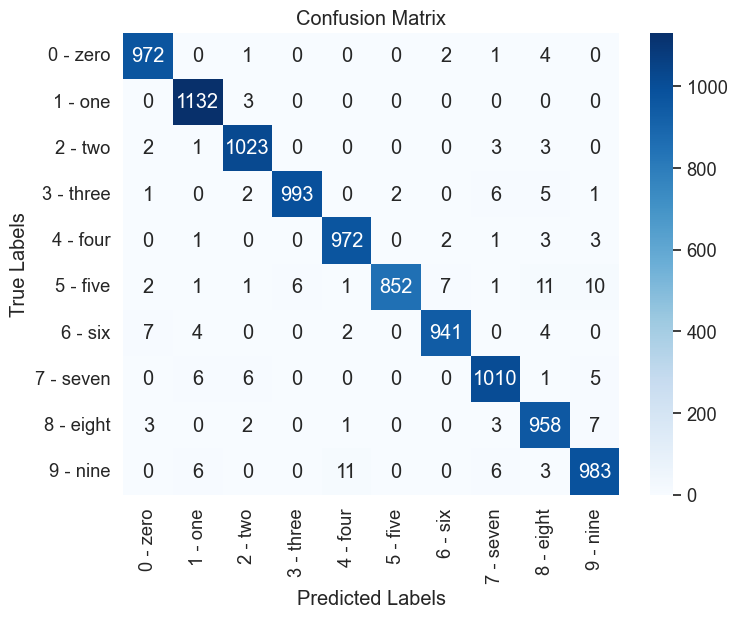

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract class labels from the dataset
class_labels = testset.classes

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set_theme(font_scale=1.2)  # Set font scale
sns.heatmap(conf_matrix, annot=True, 
            cmap="Blues", fmt="d", 
            xticklabels=class_labels, 
            yticklabels=class_labels
            )
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


**Observations/Comments:**

The model demonstrates a consistently strong performance overall. Both the classification report and the confusion matrix indicate that classes 8 and 9 exhibit slightly lower performance compared to others. However, all classes maintain an average accuracy of 0.98 and higher.

**Export the Model**

In [21]:
import os

# Define the directory path to save the model
save_dir = os.getcwd()

# Define the file name for the saved model
model_name = "mnist_dl_model.pth"
save_path = os.path.join(save_dir, model_name)

# Save the model
torch.save(net.state_dict(), save_path)

print(f"Model saved at: {save_path}")


Model saved at: c:\Users\kailo\OneDrive - Nova Scotia Community College\GDAA2010_DataModelling\Project2\mnist_dl_model.pth


**Load the Saved Model to Perform anothe Validation using the Test Dataset**

In [23]:
# The test dataset was obtained at the start of the project, in which our model
# have never seen these data at its model-building-training stage. This
# is a great data source to check if whether our previous model performance
# is inflated, or whether we have an overfitted model. 

# Define the model architecture
net_test = NeuralNet()

# Load the saved model, and push the model to GPU
net_test.load_state_dict(torch.load(save_path))
net_test.to(device)

# Evaluate the model on the test data
net_test.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net_test(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Accuracy obtained from test images: {accuracy:.2f}%")

Accuracy obtained from test images: 98.36%
